In [52]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def Homogrpahy(src_img, dst_img):
    sift = cv.SIFT_create()

    kpt1, des1 = sift.detectAndCompute(src_img, None)
    kpt2, des2 = sift.detectAndCompute(dst_img, None)

    FLANN_INDEX_KDTREE = 1
    index_parameters = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_parameters = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_parameters, search_parameters)
    matches = flann.knnMatch(des1, des2, k = 2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([kpt1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kpt2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 0.95)

    return H

def MatchSIFT(img1, img2):
    sift = cv.SIFT_create()

    kpt1, des1 = sift.detectAndCompute(img1, None)
    kpt2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_parameters = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_parameters = dict(checks = 50)   
    flann = cv.FlannBasedMatcher(index_parameters, search_parameters)
    matches = flann.knnMatch(des1, des2, k = 2)

    matchesMask = [[0,0] for i in range(len(matches))]

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i] = [1,0]

    draw_parameters = dict(matchColor = (0, 255, 0),
                    singlePointColor = (255, 0, 0),
                    matchesMask = matchesMask,
                    flags = cv.DrawMatchesFlags_DEFAULT)
                    
    img3 = cv.drawMatchesKnn(img1, kpt1, img2, kpt2, matches, None, **draw_parameters)

    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(img3, cmap = 'gray', vmin = 0, vmax = 255)
    ax.set_title('Matched features')
    ax.axis('off')

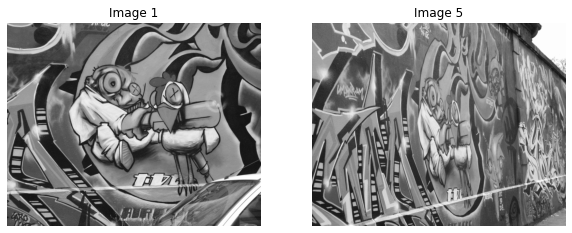

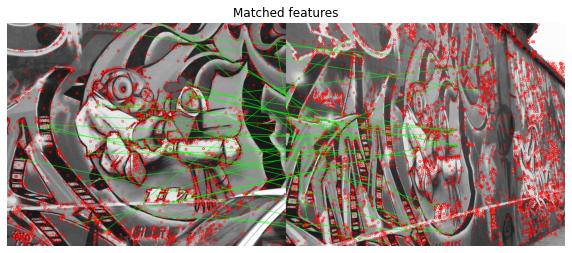

In [53]:
#a)
img1 = cv.imread(r'img1.ppm', cv.IMREAD_GRAYSCALE)
assert img1 is not None

img5 = cv.imread(r'img5.ppm', cv.IMREAD_GRAYSCALE)
assert img5 is not None

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap = 'gray', vmin = 0, vmax = 255)
ax[0].set_title('Image 1')
ax[0].axis('off')

ax[1].imshow(img5, cmap = 'gray', vmin =0, vmax=255)
ax[1].set_title('Image 5')
ax[1].axis('off')

MatchSIFT(img1, img5)

In [54]:
#b)
H = np.identity(3)

for i in range(1,5):
    src_name = str(i)+'.ppm'
    src_img = cv.imread(r'img'+src_name, cv.IMREAD_GRAYSCALE)
    assert src_img is not None

    dst_name = str(i + 1)+'.ppm'
    dst_img = cv.imread(r'img'+dst_name, cv.IMREAD_GRAYSCALE)
    assert dst_img is not None

    H = np.matmul(Homogrpahy(src_img, dst_img), H)

print(H)

[[ 6.19042336e-01  5.51020223e-02  2.21350363e+02]
 [ 2.17818387e-01  1.15112148e+00 -2.32717682e+01]
 [ 4.84302646e-04 -4.41575949e-05  9.94624567e-01]]


(-0.5, 799.5, 1279.5, -0.5)

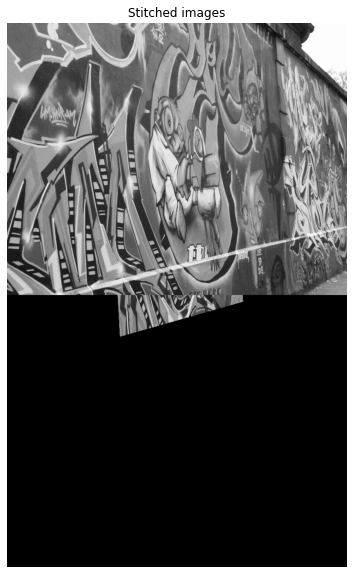

In [55]:
#c)
dst = cv.warpPerspective(src_img, H, (dst_img.shape[1], dst_img.shape[0] + src_img.shape[0])) 

dst[0:dst_img.shape[0], 0:dst_img.shape[1]] = dst_img

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(dst, cmap = 'gray', vmin = 0, vmax = 255)
ax.set_title('Stitched images')
ax.axis('off')